# ADQUISICIÓN DE DATOS

In [100]:
import pandas as pd
import matplotlib.pyplot as plt #gráficos
import seaborn as sns #gráficos más sotisficadas
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
%matplotlib inline

In [101]:
!pip install beautifulsoup4

C:\Users\hp\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\hp\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)
C:\Users\hp\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=8>
  return process_handler(cmd, _system_body)


In [102]:
!pip install selenium==3.141.0

In [103]:
from selenium import webdriver
from bs4 import BeautifulSoup 
import time

# URL que quiero analizar: Bluebikes trip history data
url = "https://s3.amazonaws.com/hubway-data/index.html"

driver_path = 'C:\\Users\\hp\\Documents\\5º E2 BA\\TFG ADE\\chromedriver-win64\\chromedriver.exe'#driver correcto para mi navegador Chrome

driver = webdriver.Chrome(driver_path) 

# Abro la URL con Selenium
driver.get(url)


time.sleep(5)  # Establezco este tiempo de 5 segundos para que la página cargue correctamente

# Obtengo el código fuente de la página
html = driver.page_source
driver.quit()

# Uso Beautiful Soup para analizar el HTML
soup = BeautifulSoup(html, 'html.parser')

# Encuentro todos los enlaces de la página
links = soup.find_all('a')

# Extraigo y muestro las URLs
for link in links:
    href = link.get('href')
    print(href)

https://s3.amazonaws.com/hubway-data/201501-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201502-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201503-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201504-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201505-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201506-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201507-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201508-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201509-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201510-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201511-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201512-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201601-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201602-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201603-hubway-tripdata.zip
https://s3.amazonaws.com/hubway-data/201

In [104]:
import os
import requests
import zipfile

# Directorio de descargas
download_dir = 'tripdata/'

# Filtro para obtener solo los enlaces de 2021 que son archivos zip
for link in links:
    href = link.get('href')
    if href.endswith('.zip') and '2021' in href:
        # Descargo el archivo zip
        file_name = os.path.basename(href)
        file_path = os.path.join('directorio/descargas', file_name)
        response = requests.get(href)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        
        # Descomprimo el archivo zip
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall('directorio/descomprimido')
        
        # Elimino el archivo zip después de descomprimirlo
        os.remove(file_path)

In [105]:
import pandas as pd


# Directorio donde se han descomprimido los archivos
extracted_dir = 'directorio/descomprimido'

# Obtengo la lista de archivos CSV en el directorio
csv_files = [file for file in os.listdir(extracted_dir) if file.endswith('.csv')]

# leo cada archivo CSV y los almaceno en una lista
dfs = []
for csv_file in csv_files:
    file_path = os.path.join(extracted_dir, csv_file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# concateno todos los dataframes en uno solo
combined_df = pd.concat(dfs, ignore_index=True)

# muestro las cinco primeras filas del dataframe
print(combined_df.head())

   tripduration                 starttime                  stoptime  \
0           914  2021-01-01 00:00:04.5900  2021-01-01 00:15:19.1680   
1          1085  2021-01-01 00:00:21.8030  2021-01-01 00:18:27.4640   
2           946  2021-01-01 00:00:26.0090  2021-01-01 00:16:12.0900   
3           355  2021-01-01 00:00:30.9210  2021-01-01 00:06:26.6000   
4           511  2021-01-01 00:01:11.2270  2021-01-01 00:09:43.1950   

   start station id                                 start station name  \
0                91   One Kendall Square at Hampshire St / Portland St   
1               370                         Dartmouth St at Newbury St   
2                46  Christian Science Plaza - Massachusetts Ave at...   
3               178                    MIT Pacific St at Purrington St   
4               386            Sennott Park Broadway at Norfolk Street   

   start station latitude  start station longitude  end station id  \
0               42.366277               -71.091690        

# TRANSFORMACIÓN DE DATOS

### Feature Engineering

In [106]:
# tenemos un par de columnas que contienen fechas. Para poder extraer más información, las pasaremos a tipo 'Datetime'
combined_df['starttime'] = pd.to_datetime(combined_df['starttime'])
combined_df['stoptime'] = pd.to_datetime(combined_df['stoptime'])

In [107]:
combined_df['weekday_start']=combined_df['starttime'].dt.weekday
combined_df['weekday_stop']=combined_df['stoptime'].dt.weekday

combined_df['weekday_start'] = pd.Categorical(combined_df['weekday_start'], categories=range(7), ordered=True)
combined_df['weekday_stop'] = pd.Categorical(combined_df['weekday_stop'], categories=range(7), ordered=True)

In [108]:
combined_df['fin_de_semana_start'] = (combined_df['weekday_start'] >= 5).astype(int)

In [109]:
combined_df['fin_de_semana_stop'] = (combined_df['weekday_stop'] >= 5).astype(int)

In [110]:
combined_df['usertype_binary'] = (combined_df['usertype'] == 'Subscriber').astype(int)

$$d_H(p,q)= 2 * R * \arcsin{\sqrt{\sin^2{(\frac{lat1 -lat2}{2})+ \cos{(lat1)* \cos{(lat2) * \sin^2{(\frac{long1 -long2}{2})}}}}}}*1000$$

In [111]:
#Distancia Haversine
from math import sin, cos, asin, degrees,sqrt, atan2, radians
def funct_dist_Haversine(lat_start, lon_start, lat_end, lon_end):
    R = 6373.0  # radio de La Tierra en Km
    lat_start = radians(lat_start)
    lon_start = radians(lon_start)
    lat_end = radians(lat_end)
    lon_end = radians(lon_end)
    dlon = lon_end - lon_start
    dlat = lat_end - lat_start
    a = sin(dlat/2)**2 + cos(lat_start) * cos(lat_end) * (sin(dlon/2))**2
    c = 2 * atan2( sqrt(a), sqrt(1-a) )
    return R * c * 1000 # pasamos a metros

In [112]:
# Añado columna al conjunto de datos con la distancia Haversine
combined_df['distance_haversine'] = combined_df.apply(lambda row: funct_dist_Haversine(row['start station latitude'],
                                                                                     row['start station longitude'],
                                                                                     row['end station latitude'],
                                                                                     row['end station longitude']), axis=1)

print(combined_df.head())

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:450: ResourceWarning: unclosed <socket.socket fd=4164, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 61096), raddr=('127.0.0.1', 61090)>
  converted = ints_to_pydatetime(


   tripduration               starttime                stoptime  \
0           914 2021-01-01 00:00:04.590 2021-01-01 00:15:19.168   
1          1085 2021-01-01 00:00:21.803 2021-01-01 00:18:27.464   
2           946 2021-01-01 00:00:26.009 2021-01-01 00:16:12.090   
3           355 2021-01-01 00:00:30.921 2021-01-01 00:06:26.600   
4           511 2021-01-01 00:01:11.227 2021-01-01 00:09:43.195   

   start station id                                 start station name  \
0                91   One Kendall Square at Hampshire St / Portland St   
1               370                         Dartmouth St at Newbury St   
2                46  Christian Science Plaza - Massachusetts Ave at...   
3               178                    MIT Pacific St at Purrington St   
4               386            Sennott Park Broadway at Norfolk Street   

   start station latitude  start station longitude  end station id  \
0               42.366277               -71.091690             370   
1           

# LIMPIEZA DE DATOS

## Analizo si hay duplicados

In [113]:
combined_df.duplicated().sum() #veo si hay duplicados

0

## Analizo si hay valores nulos

In [114]:
combined_df.isnull().sum() #veo si hay valores nulos

tripduration                    0
starttime                       0
stoptime                        0
start station id                0
start station name              0
start station latitude          0
start station longitude         0
end station id                  0
end station name                0
end station latitude            0
end station longitude           0
bikeid                          0
usertype                        0
postal code                222076
weekday_start                   0
weekday_stop                    0
fin_de_semana_start             0
fin_de_semana_stop              0
usertype_binary                 0
distance_haversine              0
dtype: int64

In [115]:
#elimino columna porque tiene muchos NAs y no tiene relevancia en la investigación
combined_df.drop('postal code', axis=1, inplace=True)
#compruebo el resultado
combined_df.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
weekday_start              0
weekday_stop               0
fin_de_semana_start        0
fin_de_semana_stop         0
usertype_binary            0
distance_haversine         0
dtype: int64

In [116]:
print(combined_df.head())

   tripduration               starttime                stoptime  \
0           914 2021-01-01 00:00:04.590 2021-01-01 00:15:19.168   
1          1085 2021-01-01 00:00:21.803 2021-01-01 00:18:27.464   
2           946 2021-01-01 00:00:26.009 2021-01-01 00:16:12.090   
3           355 2021-01-01 00:00:30.921 2021-01-01 00:06:26.600   
4           511 2021-01-01 00:01:11.227 2021-01-01 00:09:43.195   

   start station id                                 start station name  \
0                91   One Kendall Square at Hampshire St / Portland St   
1               370                         Dartmouth St at Newbury St   
2                46  Christian Science Plaza - Massachusetts Ave at...   
3               178                    MIT Pacific St at Purrington St   
4               386            Sennott Park Broadway at Norfolk Street   

   start station latitude  start station longitude  end station id  \
0               42.366277               -71.091690             370   
1           

## Análisis EDA

In [117]:
combined_df.shape 

(2934378, 19)

In [118]:
combined_df.dtypes #miro el tipo de las variables

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
weekday_start                    category
weekday_stop                     category
fin_de_semana_start                 int32
fin_de_semana_stop                  int32
usertype_binary                     int32
distance_haversine                float64
dtype: object

In [119]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934378 entries, 0 to 2934377
Data columns (total 19 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start station id         int64         
 4   start station name       object        
 5   start station latitude   float64       
 6   start station longitude  float64       
 7   end station id           int64         
 8   end station name         object        
 9   end station latitude     float64       
 10  end station longitude    float64       
 11  bikeid                   int64         
 12  usertype                 object        
 13  weekday_start            category      
 14  weekday_stop             category      
 15  fin_de_semana_start      int32         
 16  fin_de_semana_stop       int32         
 17  usertype_binary          in

In [120]:
combined_df.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,weekday_start,weekday_stop,fin_de_semana_start,fin_de_semana_stop,usertype_binary,distance_haversine
0,914,2021-01-01 00:00:04.590,2021-01-01 00:15:19.168,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,370,Dartmouth St at Newbury St,42.350961,-71.077828,5316,Customer,4,4,0,0,0,2049.432144
1,1085,2021-01-01 00:00:21.803,2021-01-01 00:18:27.464,370,Dartmouth St at Newbury St,42.350961,-71.077828,169,Edwards Playground - Main St at Eden St,42.378965,-71.068607,4917,Subscriber,4,4,0,0,1,3205.694222
2,946,2021-01-01 00:00:26.009,2021-01-01 00:16:12.090,46,Christian Science Plaza - Massachusetts Ave at...,42.343666,-71.085824,21,Prudential Center - 101 Huntington Ave,42.346520,-71.080658,2881,Customer,4,4,0,0,0,530.243506
3,355,2021-01-01 00:00:30.921,2021-01-01 00:06:26.600,178,MIT Pacific St at Purrington St,42.359573,-71.101295,107,Ames St at Main St,42.362500,-71.088220,4792,Subscriber,4,4,0,0,1,1122.833764
4,511,2021-01-01 00:01:11.227,2021-01-01 00:09:43.195,386,Sennott Park Broadway at Norfolk Street,42.368605,-71.099302,413,Kennedy-Longfellow School 158 Spring St,42.369553,-71.085790,6062,Subscriber,4,4,0,0,1,1115.367617


### Análisis variables numéricas

In [121]:
combined_df[['tripduration', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude', 'distance_haversine']].describe() #describimos las columnas numéricas

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,distance_haversine
count,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06
mean,1.785841e+03,4.235761e+01,-7.109009e+01,4.235753e+01,-7.108996e+01,1.899958e+03
std,3.259313e+04,1.781573e-02,2.738765e-02,1.788794e-02,2.743911e-02,1.385917e+03
min,6.100000e+01,4.225560e+01,-7.124776e+01,4.225560e+01,-7.124776e+01,0.000000e+00
25%,4.380000e+02,4.234810e+01,-7.110650e+01,4.234807e+01,-7.110650e+01,9.330679e+02
50%,7.420000e+02,4.235810e+01,-7.109039e+01,4.235810e+01,-7.109018e+01,1.562819e+03
75%,1.272000e+03,4.236628e+01,-7.107119e+01,4.236628e+01,-7.107116e+01,2.545343e+03
max,8.277198e+06,4.253467e+01,-7.087021e+01,4.253467e+01,-7.087021e+01,3.739266e+04


In [122]:
col_num = ['tripduration', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude','distance_haversine']
print(combined_df[col_num].corr())

                         tripduration  start station latitude  \
tripduration                 1.000000               -0.003988   
start station latitude      -0.003988                1.000000   
start station longitude      0.011746               -0.086127   
end station latitude        -0.000196                0.706254   
end station longitude        0.005270               -0.069476   
distance_haversine           0.037319               -0.044259   

                         start station longitude  end station latitude  \
tripduration                            0.011746             -0.000196   
start station latitude                 -0.086127              0.706254   
start station longitude                 1.000000             -0.067214   
end station latitude                   -0.067214              1.000000   
end station longitude                   0.683482             -0.093214   
distance_haversine                     -0.084243             -0.047262   

                         

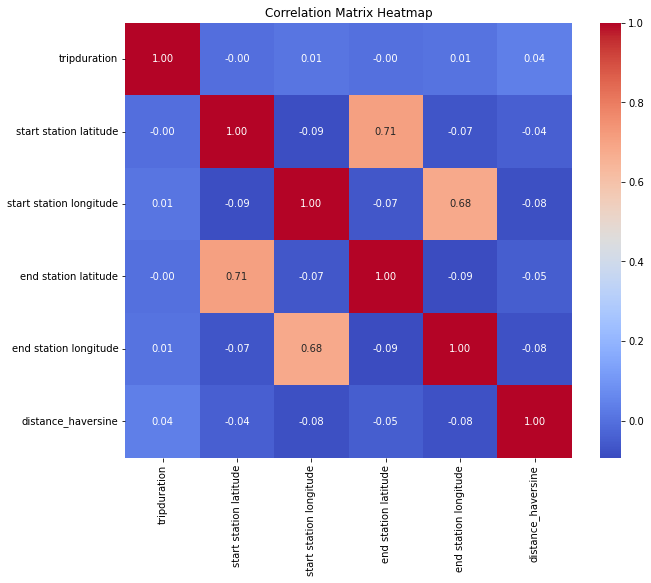

In [123]:
#analizo las correlaciones entre variables numéricas del conjunto de datos
numeric_df = combined_df[['tripduration', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude', 'distance_haversine']]
correlation_matrix = numeric_df.corr()  

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

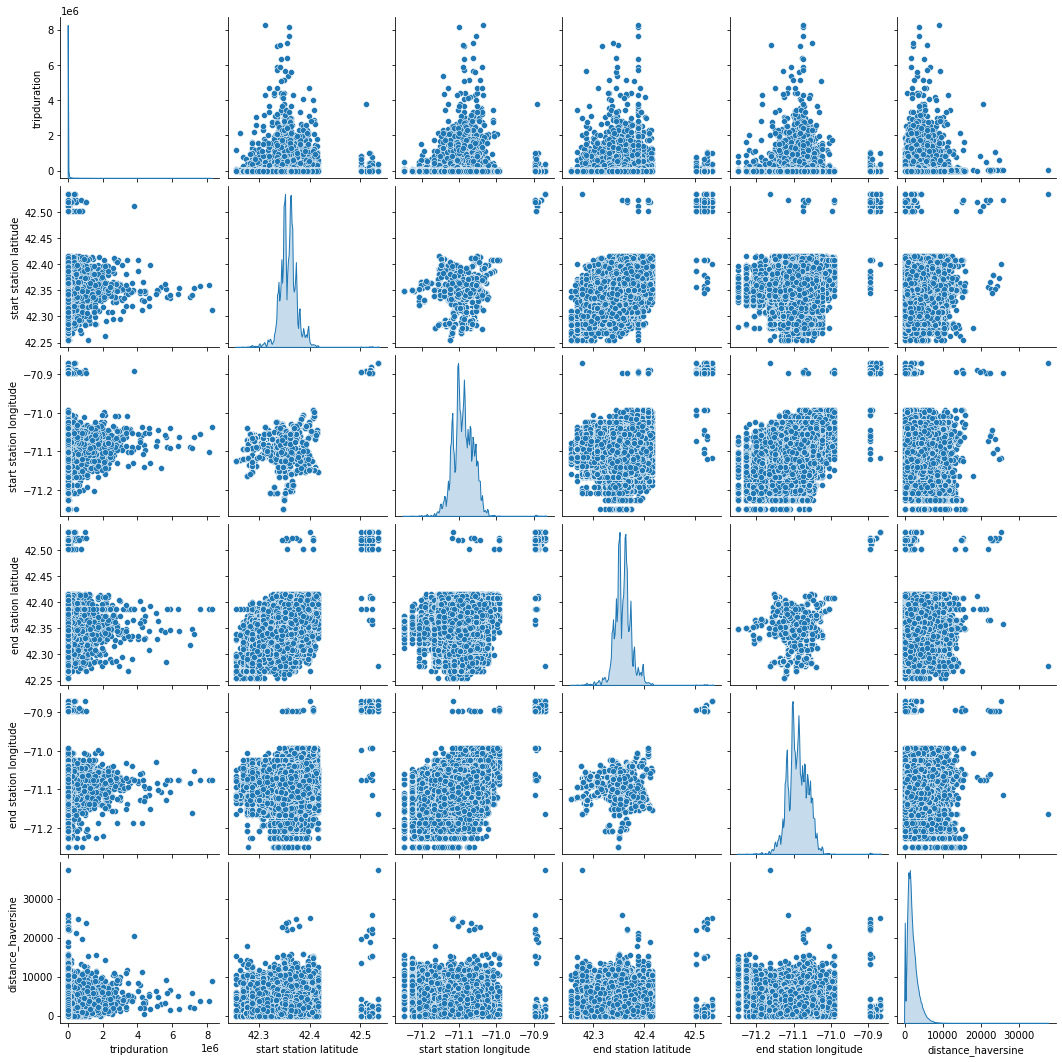

In [26]:
# creo matriz de dispersión
sample_df = combined_df.sample(frac=0.1)
sns.pairplot(combined_df[col_num],diag_kind='kde')
plt.show()

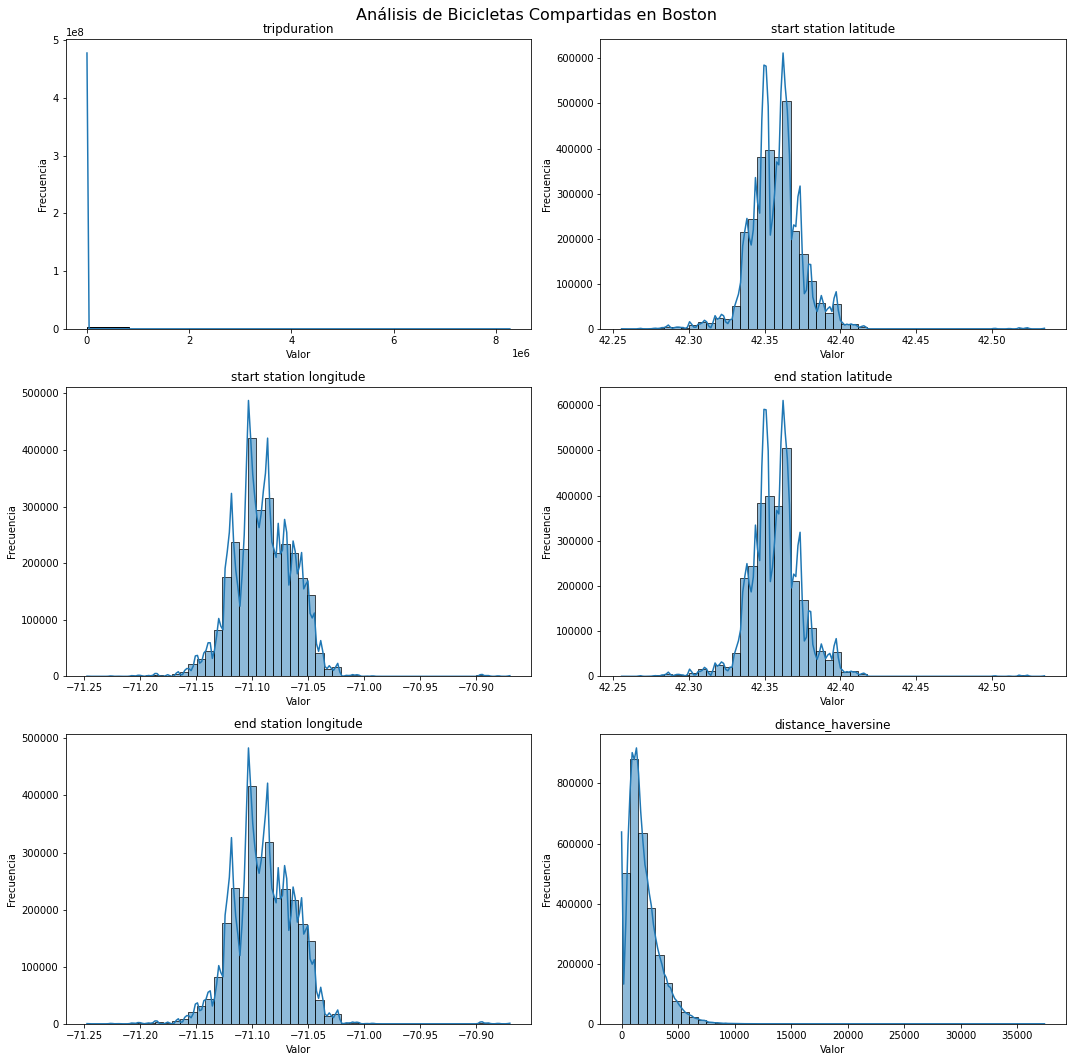

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
#dibujo histogramas
num_subgráf = len(col_num)
num_filas = (num_subgráf + 1) // 2  

fig, axes = plt.subplots(nrows=num_filas, ncols=2, figsize=(15, 5 * num_filas))
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Análisis de Bicicletas Compartidas en Boston", fontsize=16)
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(col_num):
    fila = i // 2  
    col = i % 2   
    if col_num[i] == "tripduration":
        nbins = 10
    else:
        nbins = 50
    sns.histplot(x=col_num[i], data=combined_df, ax=axes[fila, col], bins=nbins, kde=True)
    axes[fila, col].set_title(col_num[i])
    axes[fila, col].set_xlabel("Valor")  
    axes[fila, col].set_ylabel("Frecuencia") 

plt.tight_layout()
plt.show()

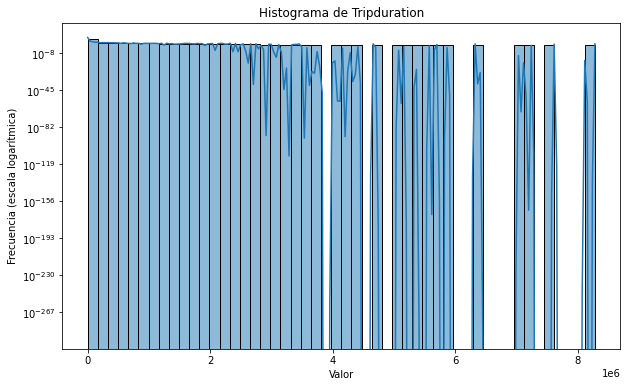

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# histograma para la variable "tripduration" con escala logarítmica en el eje y para afrontar gran variedad de datos
plt.figure(figsize=(10, 6))
sns.histplot(x="tripduration", data=combined_df, bins=50, kde=True)
plt.title("Histograma de Tripduration")
plt.xlabel("Valor")
plt.ylabel("Frecuencia (escala logarítmica)")
plt.yscale('log')  
plt.show()


### Análisis Variables Categóricas

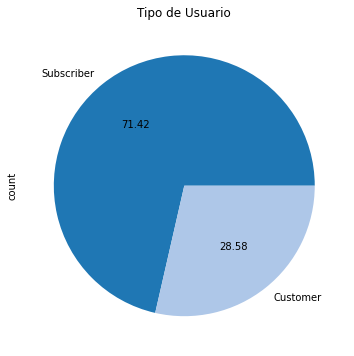

In [124]:
plot = combined_df['usertype'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Tipo de Usuario',
                                            colors=['#1f77b4', '#aec7e8'])

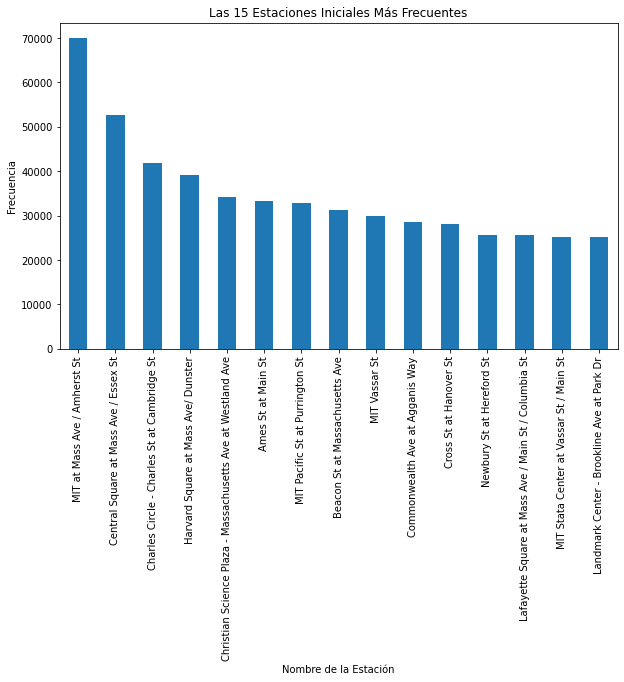

In [125]:
import matplotlib.pyplot as plt

# me quedo con las 15 estaciones más frecuentes mediante .head(15)
startstation_counts = combined_df['start station name'].value_counts()
top_15_stations = startstation_counts.head(15)

# visualizo en un gráfico de barras
plot = top_15_stations.plot(
    kind='bar', title='Las 15 Estaciones Iniciales Más Frecuentes', figsize=(10, 6))
plot.set_xlabel('Nombre de la Estación')
plot.set_ylabel('Frecuencia')
plt.xticks(rotation=90)  # giro etiquetas del eje x para poder visualizarlas mejor
plt.show()

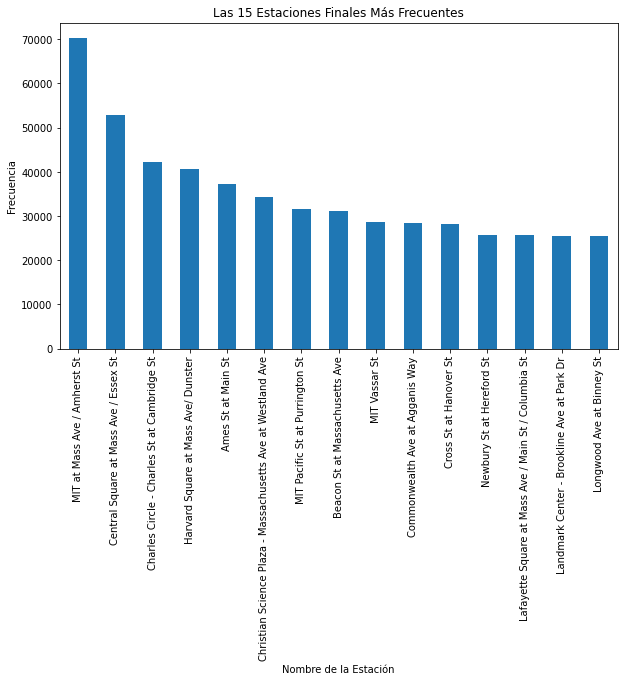

In [126]:
import matplotlib.pyplot as plt

# calculo recuento de estaciones finales
end_station_counts = combined_df['end station name'].value_counts()

# me quedo con las 15 estaciones más frecuentes mediante .head(15)
top_15_end_stations = end_station_counts.head(15)

# visualizo en un gráfico de barras
plot = top_15_end_stations.plot(
    kind='bar', title='Las 15 Estaciones Finales Más Frecuentes', figsize=(10, 6))
plot.set_xlabel('Nombre de la Estación')
plot.set_ylabel('Frecuencia')
plt.xticks(rotation=90)  # giro etiquetas del eje x para poder visualizarlas mejor
plt.show()

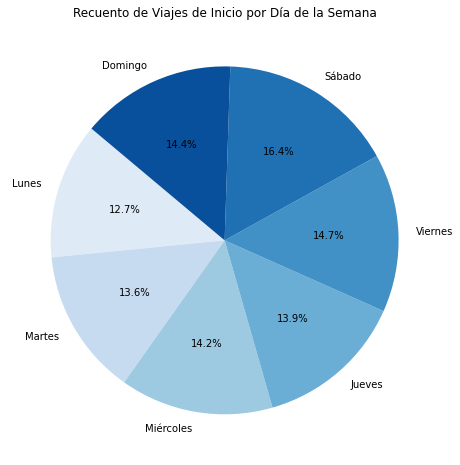

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# recuento de viajes de inicio por día de la semana
weekday_counts = combined_df['weekday_start'].value_counts()

# ordeno el conjunto de datos por el día de la semana
weekday_counts = weekday_counts.sort_index()

# asigno etiquetas a los índices de los días de la semana
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# escojo paleta de colores azul para el gráfico
colores_azules = sns.color_palette("Blues", len(dias_semana))

# Visualizo información en un gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(weekday_counts, labels=dias_semana, autopct='%1.1f%%', startangle=140, colors=colores_azules)
plt.title('Recuento de Viajes de Inicio por Día de la Semana')
plt.show()

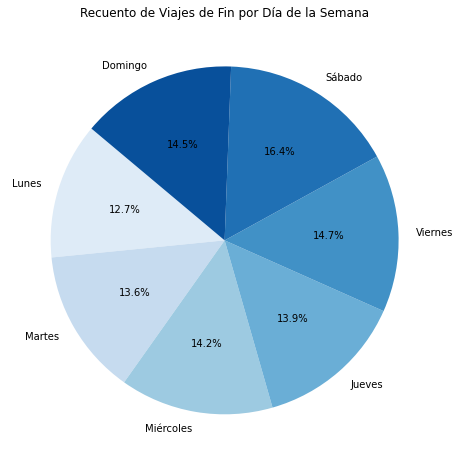

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# creo un conjunto de datos con el recuento de viajes de fin por día de la semana
weekday_counts = combined_df['weekday_stop'].value_counts()

# Ordeno el conjunto de datos por el día de la semana
weekday_counts = weekday_counts.sort_index()

# asigno etiquetas a los índices de los días de la semana
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# escojo paleta de colores azul para el gráfico
colores_azules = sns.color_palette("Blues", len(dias_semana))

# Visualizo información en un gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(weekday_counts, labels=dias_semana, autopct='%1.1f%%', startangle=140, colors=colores_azules)
plt.title('Recuento de Viajes de Fin por Día de la Semana')
plt.show()

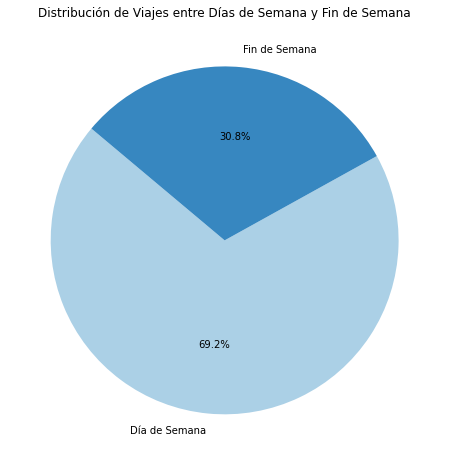

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# recuento de 'fin_de_semana_start'
weekend_counts = combined_df['fin_de_semana_start'].value_counts()

# asigno etiquetas 
etiquetas = ['Día de Semana', 'Fin de Semana']

# escojo la paletas de colores azul
colores_azules = sns.color_palette("Blues", len(etiquetas))

# Visualizo en un gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(weekend_counts, labels=etiquetas, autopct='%1.1f%%', startangle=140, colors=colores_azules)
plt.title('Distribución de Viajes entre Días de Semana y Fin de Semana')
plt.show()

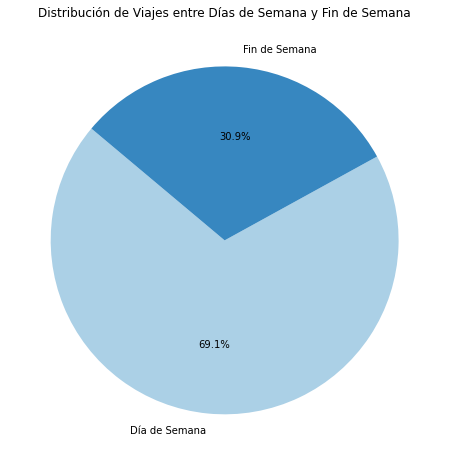

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculo recuento de viajes de parada en fin de semana
weekend_counts = combined_df['fin_de_semana_stop'].value_counts()

# asigno las etiquetas para el eje x
etiquetas = ['Día de Semana', 'Fin de Semana']

# creo la paleta de colores degradados de azul
colores_azules = sns.color_palette("Blues", len(etiquetas))

# creo el gráfico de tarta 
plt.figure(figsize=(8, 8))
plt.pie(weekend_counts, labels=etiquetas, autopct='%1.1f%%', startangle=140, colors=colores_azules)
plt.title('Distribución de Viajes entre Días de Semana y Fin de Semana')
plt.show()

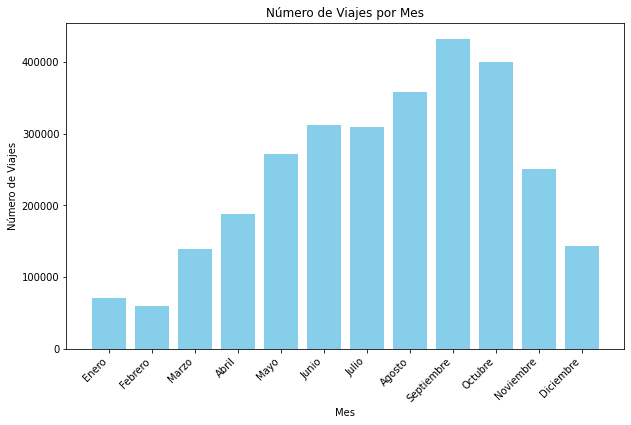

In [37]:
# recuento del número de viajes realizados en cada mes y los ordeno
monthly_trip_counts = combined_df['starttime'].dt.month.value_counts().sort_index()

# asigno etiquetas
months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# visualizo en gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(months, monthly_trip_counts, color='skyblue')

plt.title('Número de Viajes por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45, ha='right')  # giro etiquetas eje x para mejor visibilidad
plt.show()

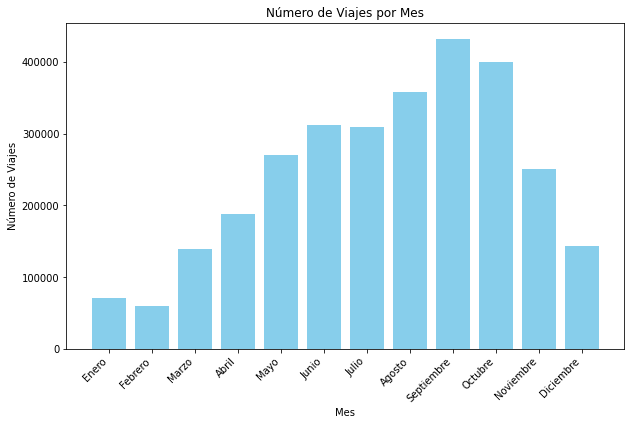

In [67]:
# cuento el número de viajes en cada mes y los ordeno
monthly_trip_counts = combined_df['stoptime'].dt.month.value_counts().sort_index()

# creo una lista de los meses en orden para asignar estas etiquetas al eje x
months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# creo el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(months, monthly_trip_counts, color='skyblue')

plt.title('Número de Viajes por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45, ha='right')  # roto las etiquetas a 45 grados para que se visualicen mejor
plt.show()

## Estudiamos outliers

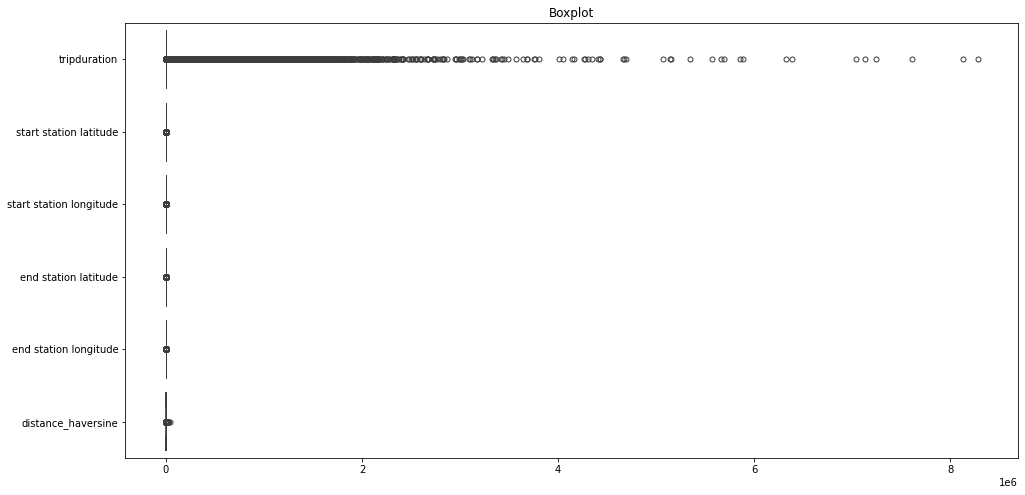

In [38]:
# ajusto tamaño de la figura
plt.figure(figsize=(16, 8))

# creo los boxplots de las variables numéricas
sns.boxplot(data=combined_df[col_num],orient='h', fliersize=5, linewidth=1, notch=True)

plt.title("Boxplot")

plt.show()

In [40]:
#regla empírica, según la cual los datos dentro de 3 veces la desviación estándar respecto a la media representan el 99.7% de los datos de la distribución

from scipy.stats import zscore

# calculo z-score para cada dato y los pongo en valor absoluto
z_scores = zscore(combined_df['tripduration'])
abs_z_scores = np.abs(z_scores)

# identifico como outliers aquellos que superen el umbral de 3
outliers = combined_df[abs_z_scores > 3]
outliers.head()

print(f'Número de outliers: {len(outliers)}')

Número de outliers: 2853


#### Para tratar con los outliers, vamos a emplear el método de winsorización 
Técnica que reemplaza los valores atípicos por el valor más cercano que no se considera un outlier según ciertos criterios 

In [41]:
from scipy.stats.mstats import winsorize

combined_df_winsorized = combined_df.copy()
combined_df_winsorized['tripduration'] = winsorize(combined_df_winsorized['tripduration'],\
  limits = [0.05, 0.05], inplace = True)

<Axes: xlabel='tripduration'>

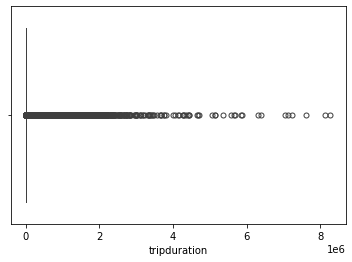

In [42]:
#boxplot de tripduration antes de emplear el método
sns.boxplot(data=combined_df['tripduration'],orient='h', fliersize=5, linewidth=1, notch=True)

<Axes: xlabel='tripduration'>

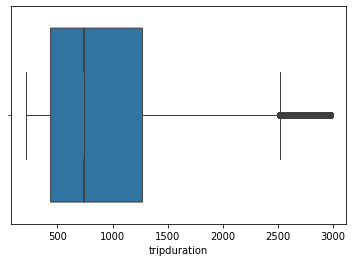

In [43]:
#boxplot de tripduration después de emplear el método
sns.boxplot(data=combined_df_winsorized['tripduration'],orient='h', fliersize=5, linewidth=1, notch=True)

#### Me descargo el dataframe en formato excel para hacer la visualización de datos con PowerBI

In [77]:
ruta_archivo_csv = 'C:\\Users\\hp\\Downloads\\BostonBPS21.csv'
combined_df.to_csv(ruta_archivo_csv, index=False)
try:
    with open(ruta_archivo_csv, 'r') as f:
        print("El archivo CSV se ha guardado correctamente.")
except FileNotFoundError:
    print("Hubo un problema al guardar el archivo CSV.")

El archivo CSV se ha guardado correctamente.


## Pregunta 1
¿Qué bicicletas tienen que ir a mantenimiento?

#### Paso 1: Cuento la frecuencia de uso de cada bicicleta

In [44]:
bike_counts = combined_df['bikeid'].value_counts()
print(bike_counts) #cuento cuántos viajes ha realizado cada bicicleta

bikeid
3489    1292
5615    1288
6678    1273
6304    1258
4507    1255
        ... 
6979       1
5534       1
7622       1
5226       1
2411       1
Name: count, Length: 4499, dtype: int64


In [45]:
#me quedo con las bicicletas que más viajes han realizado
top_bicicletas = bike_counts.head(10)
print(top_bicicletas)

bikeid
3489    1292
5615    1288
6678    1273
6304    1258
4507    1255
6241    1254
6564    1253
6858    1244
5666    1212
5712    1201
Name: count, dtype: int64


In [46]:
# filtro el dataset para quedarme con la información de los viajes de esas bicicletas más usadas
viajes_top_bicicletas = combined_df[combined_df['bikeid'].isin(top_bicicletas.index)]
print(viajes_top_bicicletas)

         tripduration               starttime                stoptime  \
881               866 2021-01-01 17:33:57.165 2021-01-01 17:48:23.902   
1433             2530 2021-01-01 20:16:44.021 2021-01-01 20:58:54.531   
1703             1278 2021-01-01 21:56:47.528 2021-01-01 22:18:05.613   
1895             1273 2021-01-02 00:00:50.372 2021-01-02 00:22:03.758   
2111             1385 2021-01-02 11:03:51.075 2021-01-02 11:26:56.588   
...               ...                     ...                     ...   
2932917          1458 2021-12-31 17:56:47.104 2021-12-31 18:21:05.959   
2933353           684 2021-12-31 19:37:22.288 2021-12-31 19:48:46.641   
2933643           609 2021-12-31 20:39:40.542 2021-12-31 20:49:50.034   
2933750          3126 2021-12-31 20:59:29.695 2021-12-31 21:51:36.297   
2934037           497 2021-12-31 22:05:57.659 2021-12-31 22:14:14.937   

         start station id                                 start station name  \
881                   330                  

In [49]:
viajes_top_bicicletas.describe() #para ver un resumen estadístico de los viajes de las 10 bicis más usadas

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,fin_de_semana_start,fin_de_semana_stop,usertype_binary,distance_haversine
count,12530.000000,12530,12530,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000
mean,1167.626417,2021-08-02 04:19:53.470121216,2021-08-02 04:39:21.596677120,172.627614,42.357779,-71.091513,171.695451,42.357718,-71.091433,5757.165283,0.313248,0.312849,0.724501,1932.927606
min,61.000000,2021-01-01 17:33:57.165000,2021-01-01 17:48:23.902000,3.000000,42.277389,-71.207650,1.000000,42.280728,-71.207650,3489.000000,0.000000,0.000000,0.000000,0.000000
25%,449.000000,2021-05-31 20:45:50.365999872,2021-05-31 20:56:49.887000064,58.000000,42.348706,-71.108100,58.000000,42.348706,-71.108100,5615.000000,0.000000,0.000000,0.000000,972.220843
50%,752.000000,2021-08-14 23:01:46.968000,2021-08-14 23:45:20.934000128,107.000000,42.358100,-71.093198,107.000000,42.358100,-71.092189,6241.000000,0.000000,0.000000,1.000000,1600.299776
75%,1263.000000,2021-10-03 17:28:57.171250176,2021-10-03 17:47:55.915249920,328.000000,42.366088,-71.072869,327.000000,42.366088,-71.072869,6564.000000,1.000000,1.000000,1.000000,2594.156004
max,349229.000000,2021-12-31 22:05:57.659000,2021-12-31 22:14:14.937000,554.000000,42.416085,-71.023739,554.000000,42.416085,-71.008942,6858.000000,1.000000,1.000000,1.000000,9980.144126
std,4264.297117,NaN,NaN,149.271339,0.016016,0.025385,149.174692,0.016090,0.025471,1007.560349,0.463833,0.463672,0.446783,1370.002394


In [50]:
# calculo la media y la desviación estándar del número de viajes
media_viajes = bike_counts.mean()
print(media_viajes)
desviacion_viajes = bike_counts.std()
print(desviacion_viajes)
      
# defino el umbral a partir del cual se considera que una bicicleta tiene que ir a mantenimiento
umbral_mantenimiento = media_viajes + 2 * desviacion_viajes  # media más dos desviaciones estándar
print(umbral_mantenimiento)

# identifico las bicicletas que necesitan mantenimiento
bicicletas_mantenimiento = bike_counts[bike_counts > umbral_mantenimiento].index

print("Las bicicletas que tienen que ir a mantenimiento son:")
print(bicicletas_mantenimiento)

652.2289397643921
281.1144799993113
1214.4578997630147
Las bicicletas que tienen que ir a mantenimiento son:
Index([3489, 5615, 6678, 6304, 4507, 6241, 6564, 6858], dtype='int64', name='bikeid')


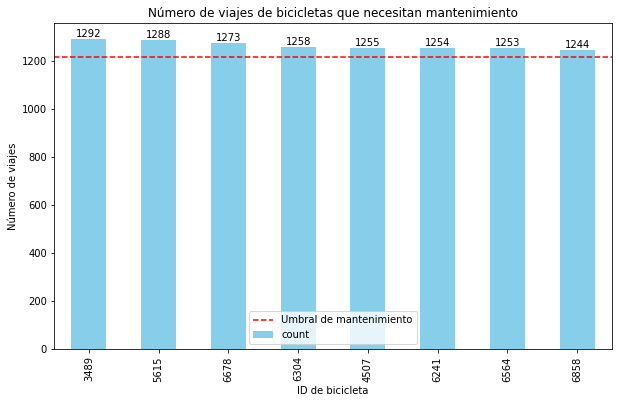

1214.4578997630147


In [51]:
viajes_bicicletas_mantenimiento = combined_df[combined_df['bikeid'].isin(bicicletas_mantenimiento)]
viajes_por_bicicleta_mantenimiento = viajes_bicicletas_mantenimiento['bikeid'].value_counts()
plt.figure(figsize=(10, 6))
grafico = viajes_por_bicicleta_mantenimiento.plot(kind='bar', color='skyblue')
plt.title('Número de viajes de bicicletas que necesitan mantenimiento')
plt.xlabel('ID de bicicleta')
plt.ylabel('Número de viajes')

# Agregar una línea horizontal en el umbral de mantenimiento
plt.axhline(y=umbral_mantenimiento, color='red', linestyle='--', label='Umbral de mantenimiento')

# Agregar etiquetas de datos en las barras
for barra in grafico.patches:
    grafico.annotate(format(barra.get_height(), '.0f'),
                     (barra.get_x() + barra.get_width() / 2,
                      barra.get_height()),
                     ha='center', va='center',
                     xytext=(0, 5),
                     textcoords='offset points')

plt.legend()
plt.show()

print(umbral_mantenimiento)

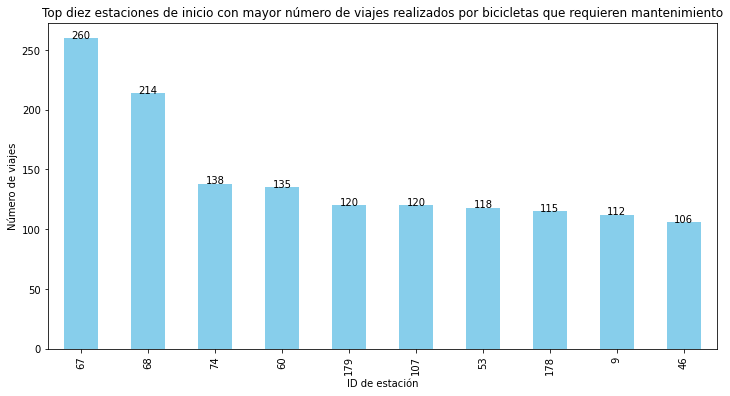

In [53]:
# obtengo las estaciones de inicio únicas para las bicicletas de mantenimiento
estacionesinicio_bibicletasmantenimiento = viajes_bicicletas_mantenimiento['start station id'].unique()

# cuento el número de viajes que realizan las bicicletas de mantenimiento por estación de inicio
viajes_por_estacion_inicio = viajes_bicicletas_mantenimiento.groupby('start station id').size()

# ordeno las estaciones por número de viajes en orden descendente
viajes_por_estacion_inicio = viajes_por_estacion_inicio.sort_values(ascending=False)

# selecciono las 10 estaciones con más viajes
top_estacionesinicio_bicicletasmantenimiento = viajes_por_estacion_inicio.head(10)
# elaboro un gráfico de barras
plt.figure(figsize=(12, 6))
top_estacionesinicio_bicicletasmantenimiento.plot(kind='bar', color='skyblue')
plt.title('Top diez estaciones de inicio con mayor número de viajes realizados por bicicletas que requieren mantenimiento')
plt.xlabel('ID de estación')
plt.ylabel('Número de viajes')
for i, v in enumerate(top_estacionesinicio_bicicletasmantenimiento):
    plt.text(i, v + 0.1, str(v), ha='center')

plt.show()

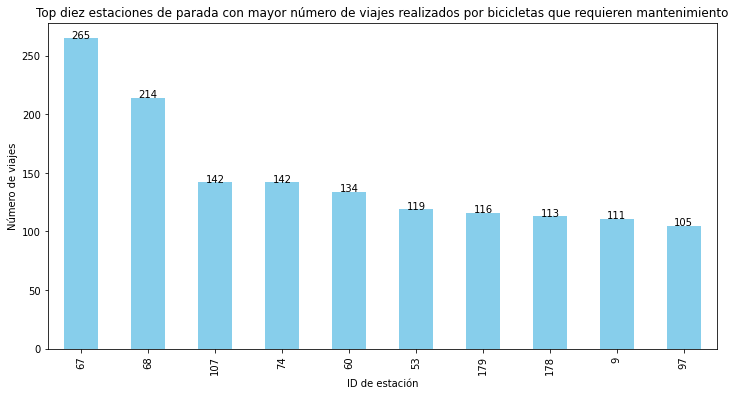

MIT at Mass Ave / Amherst St


In [54]:
# obtengo las estaciones de parada únicas para las bicicletas que necesitan mantenimiento
estacionesfin_bibicletasmantenimiento = viajes_bicicletas_mantenimiento['end station id'].unique()

# cuento el número de viajes que realizan las bicicletas de mantenimiento por estación de fin
viajes_por_estacion_fin = viajes_bicicletas_mantenimiento.groupby('end station id').size()

# ordeno las estaciones por número de viajes en orden descendente
viajes_por_estacion_fin = viajes_por_estacion_fin.sort_values(ascending=False)

# selecciono las 10 estaciones con más viajes
top_estacionesfin_bicicletasmantenimiento = viajes_por_estacion_fin.head(10)
# elaboro un gráfico de barras
plt.figure(figsize=(12, 6))
top_estacionesfin_bicicletasmantenimiento.plot(kind='bar', color='skyblue')
plt.title('Top diez estaciones de parada con mayor número de viajes realizados por bicicletas que requieren mantenimiento')
plt.xlabel('ID de estación')
plt.ylabel('Número de viajes')
for i, v in enumerate(top_estacionesfin_bicicletasmantenimiento):
    plt.text(i, v + 0.1, str(v), ha='center')

plt.show()

print(viajes_bicicletas_mantenimiento.loc[viajes_bicicletas_mantenimiento['start station id'] == 67, 'start station name'].iloc[0])

In [56]:
# obtengo las 10 rutas más realizadas
top_rutas = viajes_bicicletas_mantenimiento.groupby(['start station id', 'end station id']).size().nlargest(10)
# itero sobre las rutas más realizadas
for (start_id, end_id), bike_counts in top_rutas.items():
    # obtengo el nombre de la estación de inicio y fin
    start_name = viajes_bicicletas_mantenimiento[viajes_bicicletas_mantenimiento['start station id'] == start_id]['start station name'].iloc[0]
    end_name = viajes_bicicletas_mantenimiento[viajes_bicicletas_mantenimiento['end station id'] == end_id]['end station name'].iloc[0]
    
    print(f'Ruta: {start_name} -> {end_name}, Viajes registrados: {bike_counts}')


Ruta: MIT at Mass Ave / Amherst St -> Beacon St at Massachusetts Ave, Viajes registrados: 20
Ruta: Commonwealth Ave at Agganis Way -> 700 Commonwealth Ave., Viajes registrados: 19
Ruta: Beacon St at Massachusetts Ave -> MIT at Mass Ave / Amherst St, Viajes registrados: 19
Ruta: MIT Pacific St at Purrington St -> Central Square at Mass Ave / Essex St, Viajes registrados: 17
Ruta: Murphy Skating Rink - 1880 Day Blvd -> Murphy Skating Rink - 1880 Day Blvd, Viajes registrados: 15
Ruta: MIT at Mass Ave / Amherst St -> Central Square at Mass Ave / Essex St, Viajes registrados: 14
Ruta: MIT at Mass Ave / Amherst St -> MIT Vassar St, Viajes registrados: 14
Ruta: B.U. Central - 725 Comm. Ave. -> Commonwealth Ave at Agganis Way, Viajes registrados: 13
Ruta: Central Square at Mass Ave / Essex St -> MIT at Mass Ave / Amherst St, Viajes registrados: 13
Ruta: Harvard Square at Mass Ave/ Dunster -> Harvard University Radcliffe Quadrangle at Shepard St / Garden St, Viajes registrados: 13


In [94]:
import folium
from folium.plugins import HeatMap
from folium.vector_layers import PolyLine, CircleMarker

# obtengo las 10 rutas más realizadas
top_rutas = viajes_bicicletas_mantenimiento.groupby(['start station id', 'end station id', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']).size().nlargest(10).index

# creo un mapa centrado en Boston introduciendo como input sus coordenadas de latitud y longitud
mapa = folium.Map(location=[42.3601, -71.0589], zoom_start=1)

# agrego una capa de calor para mostrar la densidad de viajes
HeatMap(data=viajes_bicicletas_mantenimiento[['start station latitude', 'start station longitude']]).add_to(mapa)

# itero sobre las 10 rutas más realizadas
for i, (start_station, stop_station, start_lat, start_lng, end_lat, end_lng) in enumerate(top_rutas):
    # creo una línea entre las estaciones de inicio y fin para que se visualice bien la ruta
    polyline = PolyLine(locations=[(start_lat, start_lng), (end_lat, end_lng)], color='blue', weight=5, opacity=0.8).add_to(mapa)
    
    # agrego iconos para identificar las estaciones, con color verde las de inicio y con color rojo las de parada
    folium.Marker([start_lat, start_lng], icon=folium.Icon(color='green')).add_to(mapa)
    folium.Marker([end_lat, end_lng], icon=folium.Icon(color='red')).add_to(mapa)

mapa

mapa.save('mapa_rutas_boston.html')

## Pregunta 2: ¿Existe relación entre distancia entre estaciones de Blue Bikes en Boston y uso del servicio por parte de los usuarios?

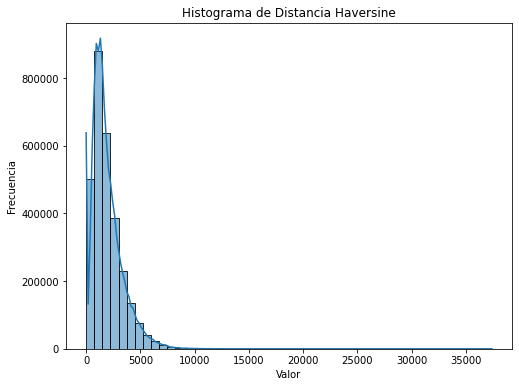

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# histograma variable "tripduration"
plt.figure(figsize=(8, 6))
sns.histplot(x="distance_haversine", data=combined_df, bins=50, kde=True)
plt.title("Histograma de Distancia Haversine")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()

In [132]:
combined_df['distance_haversine'].head()

0    2049.432144
1    3205.694222
2     530.243506
3    1122.833764
4    1115.367617
Name: distance_haversine, dtype: float64

In [133]:
combined_df['distance_haversine'].describe()

count    2.934378e+06
mean     1.899958e+03
std      1.385917e+03
min      0.000000e+00
25%      9.330679e+02
50%      1.562819e+03
75%      2.545343e+03
max      3.739266e+04
Name: distance_haversine, dtype: float64

In [134]:
# regla empírica, según la cual los datos dentro de 3 veces la desviación estándar respecto a la media representan el 99.7% de los datos de la distribución. Sabiendo esto, podemos concluir con bastante seguridad que los datos que caen más allá de este umbral son atípicos, pues son distintos al 99.7% de los datos
from scipy.stats import zscore

# Calculo z-score de cada dato y los pongo en valor absoluto
z_scores = zscore(combined_df['distance_haversine'])
abs_z_scores = np.abs(z_scores)

# identifico como outliers aquellos valores que superen el umbral de 3
outliers = combined_df[abs_z_scores > 3]
outliers.head()

print(f'Número de outliers: {len(outliers)}')

Número de outliers: 43362


In [135]:
combined_df.describe()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,fin_de_semana_start,fin_de_semana_stop,usertype_binary,distance_haversine
count,2.934378e+06,2934378,2934378,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06,2.934378e+06
mean,1.785841e+03,2021-07-31 18:20:43.798922496,2021-07-31 18:50:30.138995712,1.764975e+02,4.235761e+01,-7.109009e+01,1.756863e+02,4.235753e+01,-7.108996e+01,4.790113e+03,3.083747e-01,3.088559e-01,7.142277e-01,1.899958e+03
min,6.100000e+01,2021-01-01 00:00:04.590000,2021-01-01 00:06:26.600000,1.000000e+00,4.225560e+01,-7.124776e+01,1.000000e+00,4.225560e+01,-7.124776e+01,2.180000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.380000e+02,2021-06-01 16:44:04.416250112,2021-06-01 17:09:50.699500032,5.800000e+01,4.234810e+01,-7.110650e+01,5.800000e+01,4.234807e+01,-7.110650e+01,3.464000e+03,0.000000e+00,0.000000e+00,0.000000e+00,9.330679e+02
50%,7.420000e+02,2021-08-11 14:58:51.520000,2021-08-11 15:33:14.800000,1.100000e+02,4.235810e+01,-7.109039e+01,1.080000e+02,4.235810e+01,-7.109018e+01,4.943000e+03,0.000000e+00,0.000000e+00,1.000000e+00,1.562819e+03
75%,1.272000e+03,2021-10-05 21:27:03.186500096,2021-10-05 21:42:50.945750016,3.310000e+02,4.236628e+01,-7.107119e+01,3.310000e+02,4.236628e+01,-7.107116e+01,6.106000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.545343e+03
max,8.277198e+06,2021-12-31 23:59:59.802000,2022-01-11 16:23:36.622000,5.540000e+02,4.253467e+01,-7.087021e+01,5.540000e+02,4.253467e+01,-7.087021e+01,7.665000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.739266e+04
std,3.259313e+04,NaN,NaN,1.510204e+02,1.781573e-02,2.738765e-02,1.510996e+02,1.788794e-02,2.743911e-02,1.548857e+03,4.618223e-01,4.620217e-01,4.517816e-01,1.385917e+03


In [136]:
combined_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,weekday_start,weekday_stop,fin_de_semana_start,fin_de_semana_stop,usertype_binary,distance_haversine
0,914,2021-01-01 00:00:04.590,2021-01-01 00:15:19.168,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,370,Dartmouth St at Newbury St,42.350961,-71.077828,5316,Customer,4,4,0,0,0,2049.432144
1,1085,2021-01-01 00:00:21.803,2021-01-01 00:18:27.464,370,Dartmouth St at Newbury St,42.350961,-71.077828,169,Edwards Playground - Main St at Eden St,42.378965,-71.068607,4917,Subscriber,4,4,0,0,1,3205.694222
2,946,2021-01-01 00:00:26.009,2021-01-01 00:16:12.090,46,Christian Science Plaza - Massachusetts Ave at...,42.343666,-71.085824,21,Prudential Center - 101 Huntington Ave,42.346520,-71.080658,2881,Customer,4,4,0,0,0,530.243506
3,355,2021-01-01 00:00:30.921,2021-01-01 00:06:26.600,178,MIT Pacific St at Purrington St,42.359573,-71.101295,107,Ames St at Main St,42.362500,-71.088220,4792,Subscriber,4,4,0,0,1,1122.833764
4,511,2021-01-01 00:01:11.227,2021-01-01 00:09:43.195,386,Sennott Park Broadway at Norfolk Street,42.368605,-71.099302,413,Kennedy-Longfellow School 158 Spring St,42.369553,-71.085790,6062,Subscriber,4,4,0,0,1,1115.367617


In [138]:
from scipy.stats.mstats import winsorize
import seaborn as sns

# empleo método winsorización 
combined_df['distance_haversine'] = winsorize(combined_df['distance_haversine'], limits=[0.0025, 0.0025])
combined_df['tripduration'] = winsorize(combined_df['tripduration'], limits=[0.0025, 0.0025])

<Axes: xlabel='tripduration'>

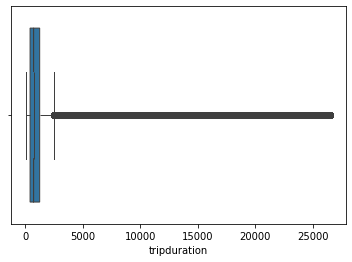

In [67]:
#este es el boxplot de tripduration antes de emplear el método
sns.boxplot(data=combined_df['tripduration'],orient='h', fliersize=5, linewidth=1, notch=True)

<Axes: xlabel='tripduration'>

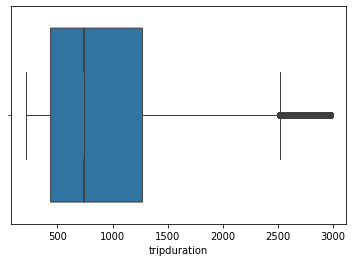

In [68]:
#este es el boxplot de tripduration antes de emplear el método
sns.boxplot(data=combined_df_winsorized['tripduration'],orient='h', fliersize=5, linewidth=1, notch=True)

<Axes: xlabel='distance_haversine', ylabel='tripduration'>

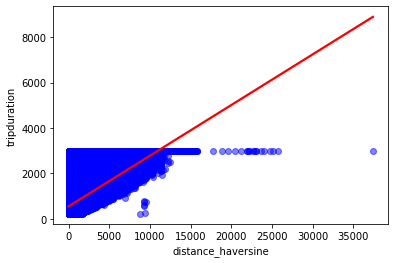

In [139]:
import seaborn as sns

sns.regplot(data=combined_df_winsorized, x='distance_haversine', y='tripduration',
            scatter_kws={"color": "blue", "alpha": 0.5},
            line_kws={"color": "red"})

In [140]:
# establezco los intervalos de distancia 
intervalos = [0, 1000, 2000, 40000]

# asigno las etiquetas para los grupos de distancia 
etiquetas = ['Distancia Corta', 'Distancia Media', 'Distancia Larga']

# añado una nueva columna al conjunto de datos con la clasificación de la variable distancia en las categorías que hemos definido
combined_df['Grupo_distancia'] = pd.cut(combined_df['distance_haversine'], bins=intervalos, labels=etiquetas, include_lowest=True)

# imprimo las cinco primeras filas del DataFrame con la nueva columna de grupos de distancia
print(combined_df[['start station id', 'distance_haversine', 'Grupo_distancia']].head())


   start station id  distance_haversine  Grupo_distancia
0                91         2049.432144  Distancia Larga
1               370         3205.694222  Distancia Larga
2                46          530.243506  Distancia Corta
3               178         1122.833764  Distancia Media
4               386         1115.367617  Distancia Media


In [141]:
metrics_by_distance = combined_df.groupby('Grupo_distancia').agg({
    'tripduration': 'mean',  # duración promedio del viaje
    'bikeid': 'count'  # número de viajes
})
print(metrics_by_distance)

                 tripduration   bikeid
Grupo_distancia                       
Distancia Corta   1035.937475   802020
Distancia Media    814.763480  1050050
Distancia Larga   1524.478433  1082308


<ipython-input-142-563563570436>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=frecuencia_por_grupo.index, y=frecuencia_por_grupo.values, palette="Blues_d")


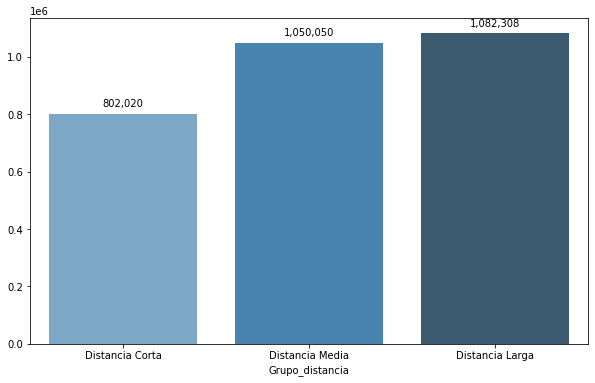

In [142]:
import matplotlib.pyplot as plt

# recuento de cada grupo de distancia
frecuencia_por_grupo = combined_df['Grupo_distancia'].value_counts()

# histograma con viajes realizados por grupo de distancia
plt.figure(figsize=(10, 6))
ax=sns.barplot(x=frecuencia_por_grupo.index, y=frecuencia_por_grupo.values, palette="Blues_d")
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

Grupo_distancia  Distancia Corta  Distancia Media  Distancia Larga
Días                                                              
Lunes                     108407           134395           129276
Martes                    112487           146439           140978
Miércoles                 115400           153979           148570
Jueves                    112833           149963           145035
Viernes                   117454           158269           156005
Sábado                    121732           163962           196377
Domingo                   113707           143043           166067


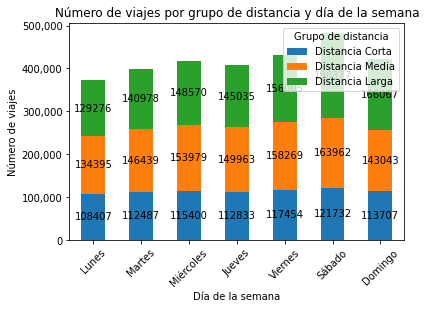

In [143]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# establezco los intervalos para los días de la semana 
intervalos = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]

# asigno las etiquetas para los días de la semana
etiquetas = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# agrego una nueva columna al conjunto de datos con la clasificación de los días en los días de la semana, en lugar de tener el índice de 0 a 6
combined_df['Días'] = pd.cut(combined_df['starttime'].dt.weekday, bins=intervalos, labels=etiquetas, include_lowest=True)

# cuento el número de viajes por día de la semana y grupo de distancia 
day_counts = combined_df.groupby(['Días', 'Grupo_distancia']).size().unstack()
print(day_counts)
# visualizo los resultados en un gráfico de barras
ax = day_counts.plot(kind='bar', stacked=True)
plt.xlabel('Día de la semana')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por grupo de distancia y día de la semana')
plt.legend(title='Grupo de distancia')
plt.xticks(rotation=45)

# asigno etiquetas de datos para cada grupo de distancia en su correspondiente segmento de la barra acumulada 
for p in ax.containers:
    ax.bar_label(p, label_type='center')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()


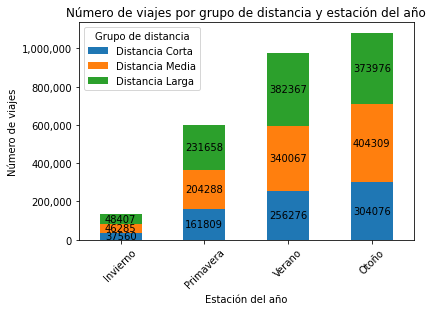

In [76]:
import matplotlib.pyplot as plt

# establezco intervalos de estaciones
intervalos = [-1, 2, 5, 8, 11]

# asigno etiquetas de las estaciones del año
etiquetas = ['Invierno', 'Primavera', 'Verano', 'Otoño']

# añado una nueva columna al conjunto de datos con la clasificación de los meses en estaciones del año
combined_df['Estaciones'] = pd.cut(combined_df['starttime'].dt.month, bins=intervalos, labels=etiquetas, include_lowest=True)

# cuento el número de viajes por estación del año y grupo de distancia 
station_counts = combined_df.groupby(['Estaciones', 'Grupo_distancia']).size().unstack()

# visualizo los resultados en un gráfico de barras
ax = station_counts.plot(kind='bar', stacked=True)
plt.xlabel('Estación del año')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por grupo de distancia y estación del año')
plt.legend(title='Grupo de distancia')
plt.xticks(rotation=45)

# asigno etiquetas de datos para cada grupo de distancia en su correspondiente segmento de la barra acumulada 
for p in ax.containers:
    ax.bar_label(p, label_type='center')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()


In [144]:
# calculo la cantidad de viajes realizados por tipo de usuario para cada grupo de distancia
viajes_por_grupo_y_usuario = combined_df.groupby(['Grupo_distancia', 'usertype']).size()
print(viajes_por_grupo_y_usuario)

Grupo_distancia  usertype  
Distancia Corta  Customer      206594
                 Subscriber    595426
Distancia Media  Customer      266938
                 Subscriber    783112
Distancia Larga  Customer      365032
                 Subscriber    717276
dtype: int64


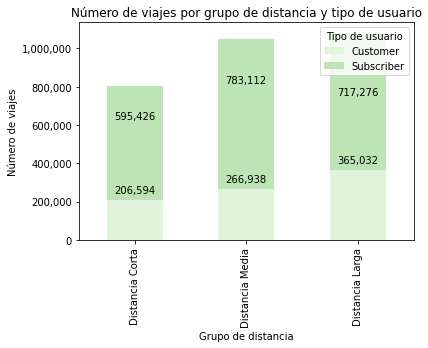

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# calculo el número de viajes realizados por tipo de usuario para cada grupo de distancia
counts = combined_df.groupby(['Grupo_distancia', 'usertype']).size().unstack()

sns.set_palette("Greens")

# visualizo el número de viajes por grupo de distancia y tipo de usuario
ax = counts.plot(kind='bar', stacked=True)

plt.xlabel('Grupo de distancia')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por grupo de distancia y tipo de usuario')
plt.legend(title='Tipo de usuario', loc='upper right')

# asigno etiquetas de datos para cada tipo de usuario en su correspondiente segmento de la barra acumulada 
for p in ax.patches:
    ax.annotate(format(int(p.get_height()), ','), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.show()

## Pregunta 3: ¿Cómo afecta la hora del día, la latitud de origen y la latitud de destino a la duración de los viajes en bicicleta compartida?

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [83]:
# creo variables hora de inicio y hora de parada
combined_df['HoradeldíaInicio'] = combined_df['starttime'].dt.hour
combined_df['HoradeldíaParada'] = combined_df['stoptime'].dt.hour

X = combined_df[['start station latitude', 'end station latitude', 'HoradeldíaInicio','HoradeldíaParada','distance_haversine']]
y = combined_df['tripduration']

In [84]:
# se ha reducido el tamaño del conjunto de entrenamiento para agilizar la carga pues son demasiadas observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100000, test_size=0.2, random_state=125)

print(f"Tamaño conjunto entrenamiento: {X_train.shape[0]}")
print(f"Tamaño conjunto test: {X_test.shape[0]}")

Tamaño conjunto entrenamiento: 100000
Tamaño conjunto test: 586876


In [85]:
# se normalizan los datos de entrenamiento y test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
# creo el modelo de Random Forest
random_forest = RandomForestRegressor(n_estimators=10, criterion = 'squared_error',max_depth = None,max_features = 1,oob_score= False,n_jobs= -1, random_state=123)

In [88]:
# entreno el modelo
random_forest.fit(X_train_scaled, y_train)

RandomForestRegressor(max_features=1, n_estimators=10, n_jobs=-1,
                      random_state=123)

In [89]:
# predicciones en el conjunto de prueba
y_pred = random_forest.predict(X_test_scaled)

In [92]:
mse = mean_squared_error(y_test, y_pred)
print("El error cuadrático medio:", mse)

El error cuadrático medio: 1122168.8350687593


In [93]:
# Búsqueda de hiperparámetro óptimo de número de árboles mediante la validación con Out-of-Bag error
# ==============================================================================
warnings.filterwarnings('ignore')
train_scores = []
oob_scores   = []
estimator_range = range(1, 150, 20)

for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

Valor óptimo de n_estimators: 141


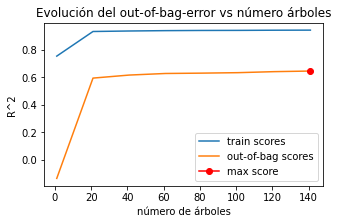

In [94]:
# visualizo en un gráfico la evolución del error out-of-bag con diferentes valores de número de árboles
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("número de árboles")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")
warnings.filterwarnings('default')

In [96]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [97]:
train_scores = []
cv_scores    = []

estimator_range = range(1, 150, 20)

for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    # error de entrenamiento
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X=X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predicciones))
    train_scores.append(rmse_train)
    
    # error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    cv_scores.append(-1*scores.mean())

Valor óptimo de n_estimators: 81


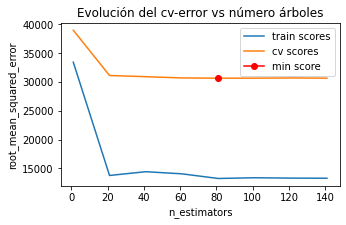

In [85]:
# visualizo en un gráfico la evolución del error de validación cruzada con diferentes valores de número de árboles
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

In [86]:
# Búsqueda de hiperparámetro óptimo de número de predictores mediante la validación con Out-of-Bag error
train_scores = []
oob_scores   = []

max_features_range = range(1, X_train.shape[1] + 1, 1)

for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

Valor óptimo de max_features: 1


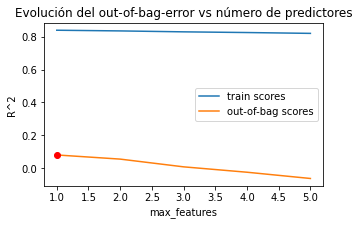

In [87]:
# visualizo en un gráfico la evolución del error out-of-bag con diferentes valores de número de predictores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

In [88]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_scores = []
cv_scores    = []

max_features_range = range(1, X_train.shape[1] + 1, 1)


for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    mse_train = mean_squared_error(y_true=y_train, y_pred=predicciones)
    rmse_train = np.sqrt(mse_train)
    train_scores.append(rmse_train)
    
    # error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    cv_scores.append(-1*scores.mean())

Valor óptimo de max_features: 1


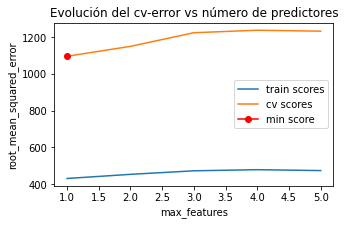

In [144]:
# visualizo en un gráfico la evolución del error de validación cruzada con diferentes valores de número de predictores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

### Grid Search

In [91]:
from sklearn.model_selection import ParameterGrid

In [92]:
# Grid search de combinación de hiperparámetros óptimos
param_grid = ParameterGrid(
                {'n_estimators': [145],
                 'max_features': [1,5,7],
                 'max_depth'   : [None,10, 20]
                }
             )

# bucle para entrenar un modelo con cada combinación de hiperparámetros
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': 1, 'n_estimators': 145} ✓
Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 145} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 145} ✓
Modelo: {'max_depth': 10, 'max_features': 1, 'n_estimators': 145} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 145} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 145} ✓
Modelo: {'max_depth': 20, 'max_features': 1, 'n_estimators': 145} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 145} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 145} ✓


,oob_r2,max_depth,max_features,n_estimators
0,0.081453,NaN,1.0,145.0
3,0.074555,10.0,1.0,145.0
6,0.073903,20.0,1.0,145.0
7,-0.042257,20.0,5.0,145.0


In [145]:
print("Mejores hiperparámetros encontrados (oob-r2)")
print(resultados.iloc[0,0:])

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
mean_fit_time                                                 145.359202
std_fit_time                                                    9.413449
mean_score_time                                                51.525594
std_score_time                                                 16.405953
param_max_depth                                                     None
param_max_features                                                     1
param_n_estimators                                                   145
params                 {'max_depth': None, 'max_features': 1, 'n_esti...
split0_test_score                                          -43321.038512
split1_test_score                                          -28949.971323
split2_test_score                                           -43277.83894
split3_test_score                                          -21

## Grid Search basado en validación cruzada

In [98]:
from multiprocessing import cpu_count
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'n_estimators': [145],
              'max_features': [1,5, 7],
              'max_depth'   : [None, 3, 10]
             }

grid = GridSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_grid = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X=X_train, y=y_train)

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

In [98]:
# Mejores hiperparámetros encontrados mediante validación cruzada
print("Mejores hiperparámetros encontrados (cv)")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': None, 'max_features': 1, 'n_estimators': 145} : -28789.174962801742 neg_root_mean_squared_error


In [102]:
from sklearn.metrics import mean_squared_error
import numpy as np

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [103]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error cuadrático medio (RMSE) de test es: {rmse}")

El error (RMSE) de test es: 31301.13319361835


## Bayesian search

In [107]:
!pip install optuna
import optuna

C:\Users\hp\anaconda3\lib\threading.py:874: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  del self._target, self._args, self._kwargs
C:\Users\hp\anaconda3\lib\threading.py:874: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  del self._target, self._args, self._kwargs
C:\Users\hp\anaconda3\lib\threading.py:874: ResourceWarning: unclosed file <_io.BufferedReader name=8>
  del self._target, self._args, self._kwargs


In [108]:
# Bayesian search de combinación de hiperparámetros óptimos
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'max_features': trial.suggest_float('max_features', 0.2, 1.0),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 1),
        'n_jobs': -1,
        'random_state': 4576688,
        
    }

    modelo = RandomForestRegressor(**params)
    cross_val_scores = cross_val_score(
        estimator = modelo,
        X = X_train,
        y = y_train,
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        scoring = 'neg_root_mean_squared_error',
        n_jobs=-1
    )
    score = np.mean(cross_val_scores) 
    return score

study = optuna.create_study(direction='maximize') # Se maximiza por que el score es negativo
study.optimize(objective, n_trials=30, show_progress_bar=True, timeout=60*5)

print('Mejores hiperparámetros:', study.best_params)
print('Mejor puntuación:', study.best_value)

[I 2024-04-14 19:03:09,309] A new study created in memory with name: no-name-2d48f45b-8c12-4f0a-8b8d-9672615fea8f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-04-14 19:07:39,044] Trial 0 finished with value: -29776.070679579956 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 75, 'max_features': 0.5693638349228538, 'ccp_alpha': 0.3695098845722006}. Best is trial 0 with value: -29776.070679579956.
[I 2024-04-14 19:13:59,293] Trial 1 finished with value: -29845.556163608093 and parameters: {'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 70, 'max_features': 0.6350459188832622, 'ccp_alpha': 0.8701030518376907}. Best is trial 0 with value: -29776.070679579956.
Mejores hyperparameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 75, 'max_features': 0.5693638349228538, 'ccp_alpha': 0.3695098845722006}
Mejor score: -29776.070679579956


In [109]:
modelo_final = RandomForestRegressor(**study.best_params)
modelo_final.fit(X_train, y_train)
predicciones = modelo_final.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 32538.239320467826


### Pregunta 4. ¿Cómo influyen la hora del día y la ubicación en la probabilidad de que un viaje en bicicleta compartida sea corto (menos de 29 minutos) o largo (más de 29 minutos)?

In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# calculo el promedio de duración de viajes
promedio_trip_duration = combined_df['tripduration'].mean()
print(promedio_trip_duration)

# defino ese valor del promedio como umbral para la clasificación 
umbral_tripduration = promedio_trip_duration

# creo nueva columna en el conjunto de datos de tipo binaria para determinar si un viaje es largo (1) o corto (0)
combined_df['Duración Larga'] = (combined_df['tripduration'] > umbral_tripduration).astype(int)
print(combined_df['Duración Larga'].head(5))

X = combined_df[['start station latitude', 'end station latitude', 'HoradeldíaInicio', 'distance_haversine']]
y = combined_df['Duración Larga']  # Cambiar 'tripduration' por 'Duración Larga'


1785.8405345187293
0    0
1    0
2    0
3    0
4    0
Name: Duración Larga, dtype: int32


In [126]:
# se ha reducido el tamaño del conjunto de entrenamiento para agilizar la carga pues son demasiadas observaciones
X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(X, y, train_size=100000, test_size=0.2, random_state=125)
print(f"Tamaño conjunto entrenamiento: {X_train.shape[0]}")
print(f"Tamaño conjunto test: {X_test.shape[0]}")

Tamaño conjunto entrenamiento: 100000
Tamaño conjunto test: 586876


In [129]:
# entreno modelo Random Forest de clasificación  
model = RandomForestClassifier()  
model.fit(X_train_clas, y_train_clas)


RandomForestClassifier()

In [130]:
# calculo las probabilidades de las clases positivas
y_prob = model.predict_proba(X_test_clas)[:, 1]

In [131]:
#calculo el área bajo la curva ROC
roc_auc = roc_auc_score(y_test_clas, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print("Área bajo la curva ROC:", roc_auc)

Área bajo la curva ROC: 0.7964462082530956


Área bajo la curva ROC: 0.7964462082530956


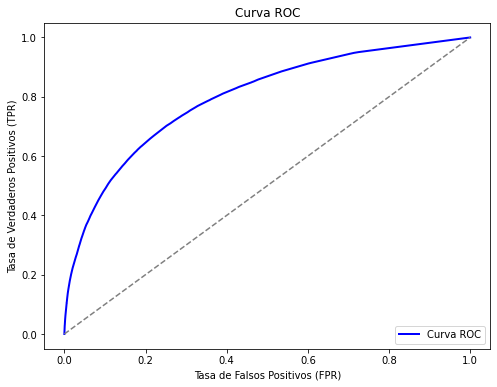

In [132]:
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
print(f"Área bajo la curva ROC: {auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# visualizo la curva ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

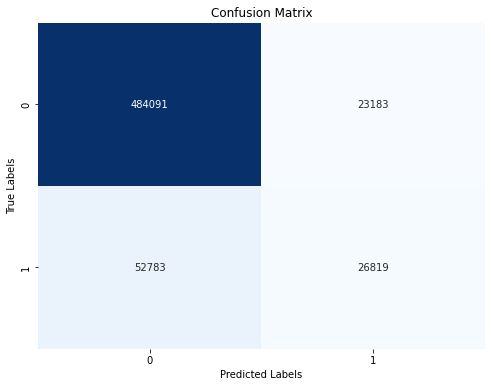

In [133]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

# creo la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()